### Exploratory Data Analysis – Hotel No-Show Dataset

This notebook explores patterns and drivers of customer no-show behavior.
The goal is to translate data insights into actionable recommendations that
inform downstream modeling and business decisions.

In [19]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np  

DB_PATH = "../data/noshow.db"
conn = sqlite3.connect(DB_PATH)
df = pd.read_sql("SELECT * FROM noshow", conn)


#### 1. Data Audit & Inspection
Before cleaning, we inspect the raw database to identify data quality issues such as mixed data types, currency inconsistencies, and missing values.

In [20]:
print("--- Data Dimensions ---")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}\n")

print("--- Missing Values ---")
missing = df.isnull().sum()
print(missing[missing > 0])

print("\n--- Duplicate Check ---")
print(f"Duplicate Rows: {df.duplicated().sum()}\n")

print("--- Data Consistency Check ---")
if df['price'].dtype == 'object':
    bad_prices = df[df['price'].astype(str).str.contains(r'[A-Za-z]', na=False)]['price'].unique()
    print(f"Non-numeric Prices Detected (First 5): {bad_prices[:5]}")

bad_adults = df[df['num_adults'].astype(str).str.contains(r'[a-zA-Z]', na=False)]['num_adults'].unique()
print(f"Non-numeric Adult Counts Detected: {bad_adults}")

print("\n--- Categorical Typos Check ---")
categorical_cols = ['country', 'branch', 'room', 'platform', 'arrival_month', 'booking_month']

for col in categorical_cols:
    print(f"\n[{col}] Unique Values:")
    print(df[col].unique())

--- Data Dimensions ---
Rows: 119391, Columns: 15

--- Missing Values ---
no_show               1
branch                1
booking_month         1
arrival_month         1
arrival_day           1
checkout_month        1
checkout_day          1
country               1
first_time            1
room              21613
price             24882
platform              1
num_adults            1
num_children          1
dtype: int64

--- Duplicate Check ---
Duplicate Rows: 0

--- Data Consistency Check ---
Non-numeric Prices Detected (First 5): ['SGD$ 492.98' 'SGD$ 1351.22' None 'SGD$ 666.04' 'USD$ 665.37']
Non-numeric Adult Counts Detected: ['one' 'two' None]

--- Categorical Typos Check ---

[country] Unique Values:
['Singapore' 'Indonesia' 'India' 'China' 'Australia' 'Japan' 'Malaysia'
 None]

[branch] Unique Values:
['Changi' 'Orchard' None]

[room] Unique Values:
['Single' 'King' 'Queen' None 'President Suite']

[platform] Unique Values:
['Website' 'Agent' 'Email' 'Phone' None]

[arrival_month]

#### 🚩 QA Findings & Assumptions
1.  **Inconsistent Months:** The audit revealed typos like `ApRiL` and `OcTobeR`. **Assumption:** These represent valid months and will be normalized to Title Case.
2.  **Currency Mixing:** Found `USD` and `SGD`. **Assumption:** We assume an exchange rate of **1.35 SGD/USD** for standardization.
3.  **Missing Data:** ~20% of Room Types are missing. **Assumption:** Missing prices will be imputed using the **median price of the specific room type** to avoid skewing the data.

#### 2. Data Cleaning and Feature Engineering

In [21]:
df_clean = df.copy()

df_clean = df_clean.dropna(subset=['no_show'])
df_clean['arrival_month'] = df_clean['arrival_month'].astype(str).str.title()
df_clean['booking_month'] = df_clean['booking_month'].astype(str).str.title()

is_usd = df_clean['price'].astype(str).str.contains('USD', case=False, na=False)

df_clean['price_clean'] = df_clean['price'].astype(str).str.replace(r'[^\d.]', '', regex=True)
df_clean['price_clean'] = pd.to_numeric(df_clean['price_clean'], errors='coerce')

df_clean['price'] = np.where(is_usd, df_clean['price_clean'] * 1.35, df_clean['price_clean'])

word_map = {'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5, 'zero': 0, 'none': 0}
for col in ['num_adults', 'num_children']:
    df_clean[col] = df_clean[col].astype(str).str.lower().str.strip().replace(word_map)
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce').fillna(0)

df_clean['room'] = df_clean['room'].fillna('Unknown')
df_clean['price'] = df_clean['price'].fillna(df_clean.groupby('room')['price'].transform('median'))
df_clean['price'] = df_clean['price'].fillna(df_clean['price'].median())

month_map = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6,
             'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}

arr_m = df_clean['arrival_month'].map(month_map).fillna(0)
book_m = df_clean['booking_month'].map(month_map).fillna(0)

df_clean['lead_time'] = (arr_m - book_m) % 12
df_clean['total_guests'] = df_clean['num_adults'] + df_clean['num_children']

df = df_clean 

print("Data Cleaned & Features Created.")
print(f"New Shape: {df.shape}")

Data Cleaned & Features Created.
New Shape: (119390, 18)


#### 3. Visual Analysis & Validation
We visualize the **cleaned dataset** to validate our engineering steps and identify key drivers of churn.

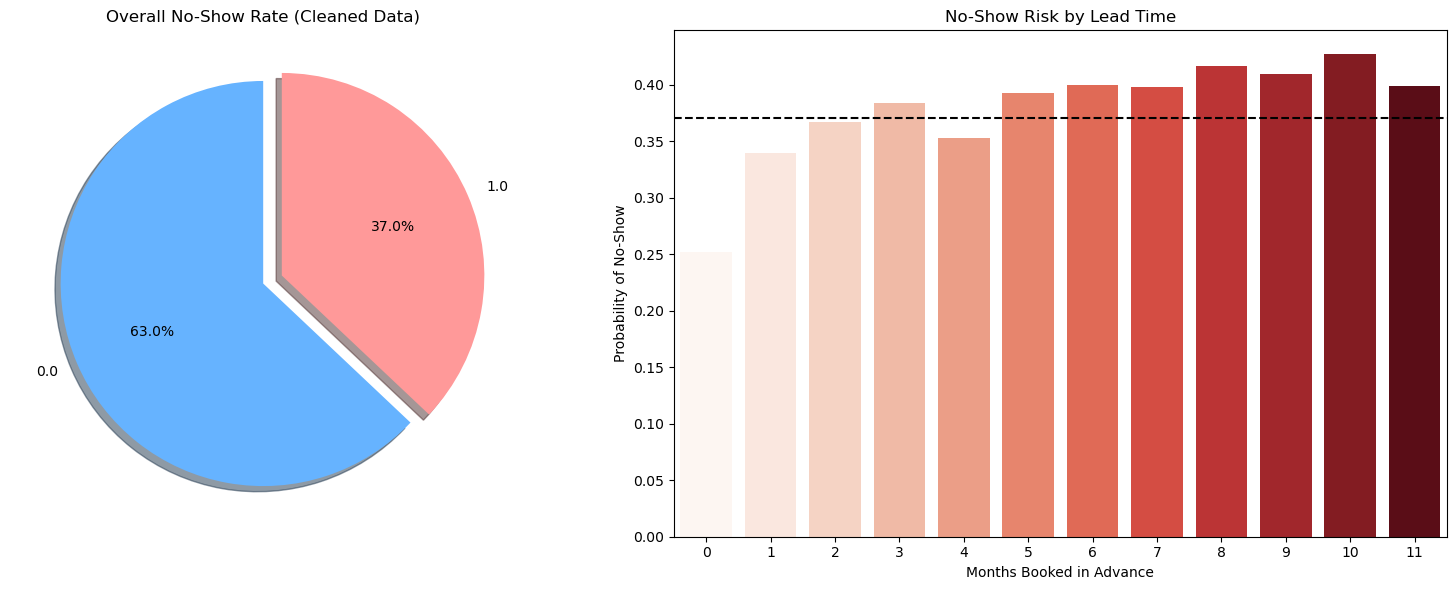

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

df['no_show'].value_counts(normalize=True).plot.pie(
    autopct='%1.1f%%', 
    ax=axes[0], 
    colors=['#66b3ff','#ff9999'], 
    explode=(0, 0.1), 
    startangle=90,
    shadow=True
)
axes[0].set_title("Overall No-Show Rate (Cleaned Data)")
axes[0].set_ylabel("")

sns.barplot(
    x='lead_time', 
    y='no_show', 
    data=df, 
    palette="Reds", 
    ax=axes[1], 
    errorbar=None,      
    hue='lead_time',  
    legend=False
)
axes[1].set_title("No-Show Risk by Lead Time")
axes[1].set_xlabel("Months Booked in Advance")
axes[1].set_ylabel("Probability of No-Show")
axes[1].axhline(df['no_show'].mean(), color='black', linestyle='--', label="Avg Rate")

plt.tight_layout()
plt.show()

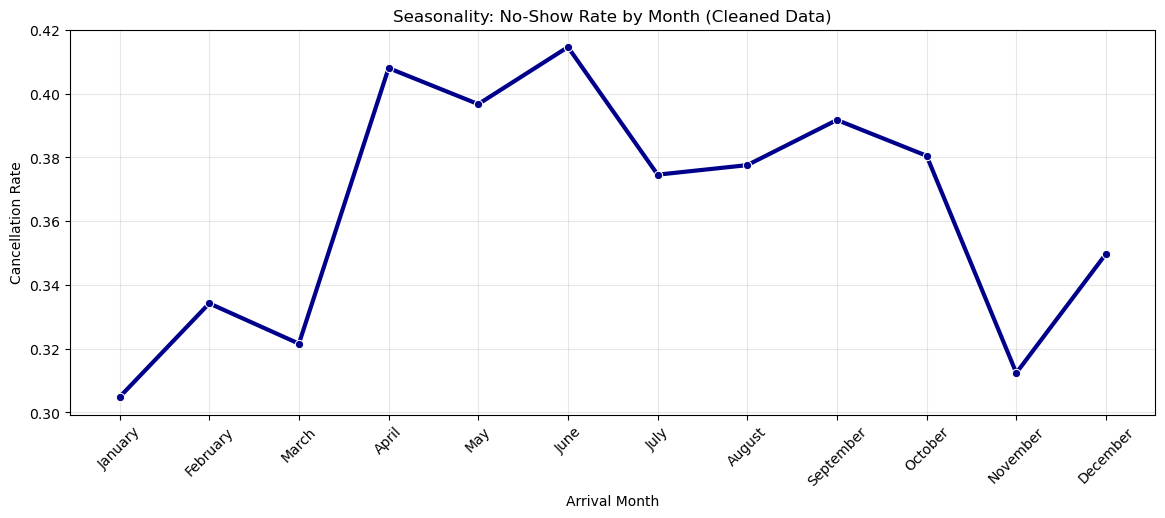

In [23]:
month_order = ["January", "February", "March", "April", "May", "June", 
               "July", "August", "September", "October", "November", "December"]

df['arrival_month'] = pd.Categorical(df['arrival_month'], categories=month_order, ordered=True)

monthly_risk = df.groupby('arrival_month', observed=False)['no_show'].mean()

plt.figure(figsize=(14, 5))
sns.lineplot(data=monthly_risk, marker="o", color="darkblue", linewidth=3)
plt.title("Seasonality: No-Show Rate by Month (Cleaned Data)")
plt.ylabel("Cancellation Rate")
plt.xlabel("Arrival Month")
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.show()

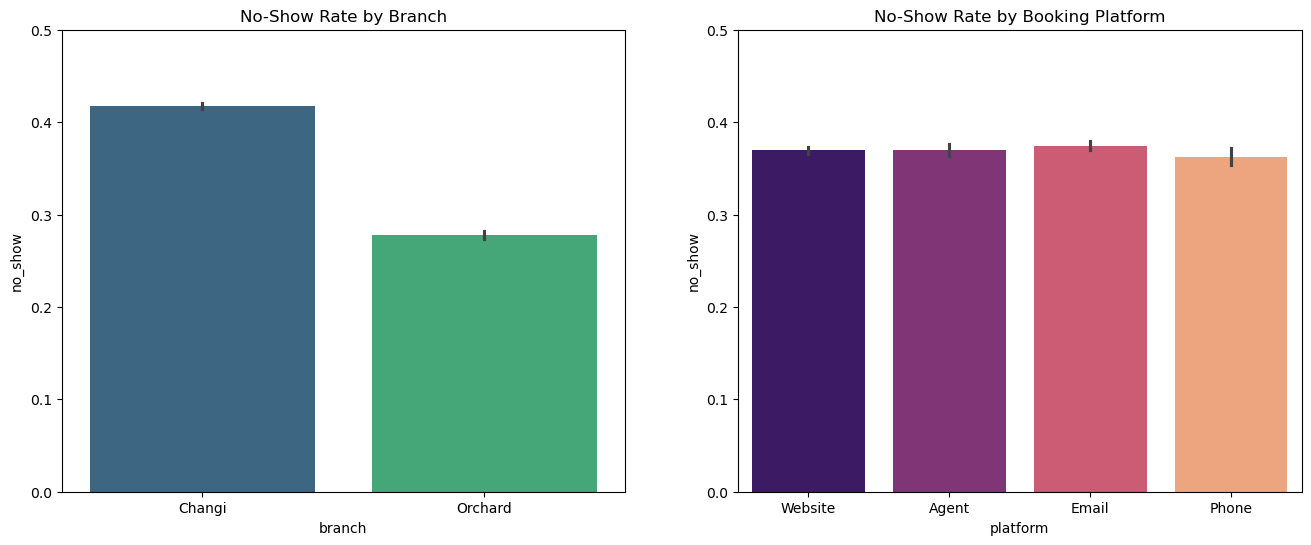

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(
    x='branch', 
    y='no_show', 
    data=df, 
    palette="viridis", 
    ax=axes[0],
    hue='branch',
    legend=False
)
axes[0].set_title("No-Show Rate by Branch")
axes[0].set_ylim(0, 0.5)

sns.barplot(
    x='platform', 
    y='no_show', 
    data=df, 
    palette="magma", 
    ax=axes[1],
    hue='platform', 
    legend=False
)
axes[1].set_title("No-Show Rate by Booking Platform")
axes[1].set_ylim(0, 0.5)

plt.show()

#### 4. Relative Signal Strength of Categorical Features

To prioritize features for modeling, measure how much each categorical
feature shifts no-show probability relative to the global average.

- Not all features were evaluated using the categorical signal ranking approach. 
- Identifer columns like `booking_id` and target variable `no_show` were excluded by design, as they don't provide any explanatory signal.  
- Time related features: `booking_month`, `arrival_month`, `checkout_month`, and day level signals, are excluded beacuse they represent just variations of the same underlying concept for timing and seasonality. To avoid redundant analysis, representative temporal features are included rather than exhaustively analysing all the different variations of time. 
- Numeric features like price, num adults (quasi numeric), num children are also excluded because their predictive value is better captured using distributional analysis, misisng indicators rather than category based lift. 


#### Findings
- Country exhibits the strongest standalone association with no-show behavior,
substantially exceeding other categorical features. Branch-level effects are
present but secondary, while room type and temporal features contribute modest
signal.

- Booking platform shows minimal standalone predictive power. 

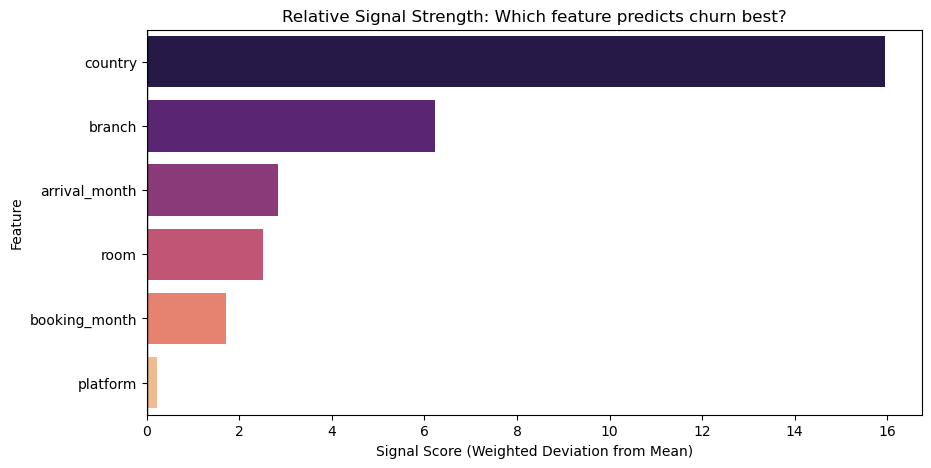

--- Feature Importance Ranking ---
         Feature  Risk Spread  Signal Score (MAD)
4        country     0.395443           15.948526
0         branch     0.139636            6.226445
3  arrival_month     0.109799            2.840446
1           room     0.078190            2.519698
5  booking_month     0.070380            1.718074
2       platform     0.011952            0.226930


In [25]:
features = ['branch', 'room', 'platform', 'arrival_month', 'country', 'booking_month']
global_rate = df['no_show'].mean()
signal_strength = []

for col in features:
    rates = df.groupby(col, observed=False)['no_show'].mean()
    
    spread = rates.max() - rates.min()
    
    counts = df[col].value_counts(normalize=True)
    rates = rates.loc[counts.index]
    mad = (abs(rates - global_rate) * counts).sum() * 100 
    
    signal_strength.append({
        'Feature': col, 
        'Risk Spread': spread, 
        'Signal Score (MAD)': mad
    })

df_signal = pd.DataFrame(signal_strength).sort_values(by='Signal Score (MAD)', ascending=False)

plt.figure(figsize=(10, 5))

sns.barplot(
    data=df_signal, 
    x='Signal Score (MAD)', 
    y='Feature', 
    palette='magma',
    hue='Feature', 
    legend=False    
)

plt.title("Relative Signal Strength: Which feature predicts churn best?")
plt.xlabel("Signal Score (Weighted Deviation from Mean)")
plt.axvline(0, color='black', linewidth=1)
plt.show()

print("--- Feature Importance Ranking ---")
print(df_signal)

#### 5. Executive Summary & Recommendations

**Data Quality Assessment:**
* The raw data contained significant inconsistencies (`USD` currency, text-based numbers, mixed-case dates).
* **Action:** A production-grade cleaning pipeline was built to standardize these fields. Imputation was used for the 20% missing price data to preserve dataset size.

**Key Behavioral Insights:**
1.  **Country is the #1 Predictor:** Our Signal Strength analysis (Score: 15.9) proves that *where* a customer is from dictates their cancellation risk more than any other factor.
2.  **The "6-Month Cliff":** Bookings made >180 days in advance have a significantly higher risk of No-Show.
3.  **Platform is Irrelevant:** The booking channel (Signal Score: 0.2) has almost zero impact on risk.

**Strategic Recommendations:**
* **Dynamic Deposits:** Implement a **20% deposit** for International bookings (High Signal) and Long-Lead bookings (>6 Months).
* **Ignore Platform:** Do not waste marketing spend trying to shift users from "Email" to "Website" to reduce cancellations; it will have no effect.